<a href="https://colab.research.google.com/github/CDL-RecSys/oeaw-ai-winter-school-2023/blob/main/Emotion_Detection_and_Recommender_Systems_%C3%96AW_AI_Winter_School_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to our second handson! 👋
In this session we will experiment with a small real world sample. We will use the title and the category of 1000 news articles sampled from the microsoft news data set, i.e. MIND data set. You can find here [https://msnews.github.iot](https://msnews.github.io) more information about the MIND data set. 


We will use pre-trained transformer models freely available on the huggingface 🤗 platform ([https://huggingface.co](https://huggingface.co)). For the first analysis, we will use the standard sentiment-analysis pipleine of the transformers library and additionally we will utilize a dictionary based sentiment analyzer (as described in the morning). The models we are using in the second part of this notebook are trained/tuned on the GoEmotions dataset; here a link to the paper: [https://ai.googleblog.com/2021/10/goemotions-dataset-for-fine-grained.html](https://ai.googleblog.com/2021/10/goemotions-dataset-for-fine-grained.html). We will use the models to extract emotions of different granularity - Sentiment, Ekman, and GoEmotions (as described in the morning session). 

**The outline looks as following**: 
- Setup
  - We will install and import all required packages and libraries
  - We will download and preprocess the data
- We will extract and compare sentiment polarity scores; we will utilized VADER and a BERT based sentiment analyzer for that. 
- We will extract, analyze, and compare emotions
- We will build a simple recommender using KNN; where we will compare emotion awareness vs. non-emotion awareness

**Feel free to reach out**:
[mete.sertkan@tuwien.ac.at](mailto:mete.sertkan@tuwien.ac.at)
or [@m_sertkan](https://twitter.com/m_sertkan)

## Prelude 

### Install required libraries

In [ ]:
# Let's pip install the needed libraries first
!pip install transformers
!pip install vaderSentiment
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 104.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 KB 4.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.8 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=0f165ac80a4b61828a349035cdd7a867cd4f3d96ef3c590c54e2515ee8d666b1
 

### Import required libraries

In [ ]:
# import the needed libraries
# transformers
from transformers import (
    BertTokenizer,
    AutoModelForSequenceClassification,
    pipeline,
    set_seed)
# sentence transformer
from sentence_transformers import SentenceTransformer
#vader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# pandas
import pandas as pd
# matplotlib
import matplotlib.pyplot as plt
# seaborn
import seaborn as sns
# torch
import torch
from torch.nn import functional as F
# numpy
import numpy as np
# sklearn knn
from sklearn.neighbors import NearestNeighbors
# tqdm
from tqdm import tqdm
# widgets
from ipywidgets import interact, interactive
import ipywidgets as widgets

In [ ]:
# Set seed for reproducibility,
set_seed(1729)

### Download sample dataset

In [ ]:
news = pd.read_csv("https://owncloud.tuwien.ac.at/index.php/s/JGD1bYMPmFo99LX/download", sep="\t", header=None, names=["id", "category", "title"])
news.title = news.title.str.strip()
news.drop(929,inplace=True)
news.reset_index(drop=True, inplace=True)

In [ ]:
news.head()

,id,category,title
0,N55528,lifestyle,"The Brands Queen Elizabeth, Prince Charles, an..."
1,N19639,health,50 Worst Habits For Belly Fat
2,N61837,news,The Cost of Trump's Aid Freeze in the Trenches...
3,N53526,health,I Was An NBA Wife. Here's How It Affected My M...
4,N38324,health,"How to Get Rid of Skin Tags, According to a De..."


## Measuring Sentiment Polarity Score

### Setup
Setup vader sentiment analyzer and bert-based sentiment analyzer.

In [ ]:
# setup our sentiment analyzers 
vader_sa = SentimentIntensityAnalyzer()
bert_sa = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

We need some helper function to extract a score between -1 and 1 given any text.

In [ ]:
# helper function to convert into sentiment score between -1 and 1
def get_bert_sentiment(text=""):
  label, score = bert_sa(text.strip())[0].values()
  if(label == "POSITIVE"):
    bert_sentiment = (1-score)*(-1) + score
  else:
    bert_sentiment = (score)*(-1) + (1-score)
  return bert_sentiment
# helper to get vader sentiment score between -1 and 1
def get_vader_sentiment(text=""):
  return vader_sa.polarity_scores(text.strip())["compound"]

### First Insights

Let's try out the sentiment extraction. Here just take the news title of the first entry.

In [ ]:
# try an example
print(f"Input: {news.title[0]}")
print(f"VADER output: {get_vader_sentiment(news.title[0])}")
print(f"BERT output: {get_bert_sentiment(news.title[0])}")

Input: The Brands Queen Elizabeth, Prince Charles, and Prince Philip Swear By
VADER output: -0.0516
BERT output: 0.4649280309677124


The input text ist "The input text ist "The Brands Queen Elizabeth, Prince Charles, and Prince Philip Swear By". Our vader sentiment analyzer outputs **-0.0516** (rather neutral), but the output of the bert based sentiment analyzer ist **0.4649** (more on the positive side). What is your opinion?

Let's calculate sentiments scores for all 1000 news articles

In [ ]:
vader_sentiment_scores = [get_vader_sentiment(title) for title in tqdm(news.title)]
bert_sentiment_scores = [get_bert_sentiment(title) for title in tqdm(news.title)]

100%|██████████| 999/999 [00:56<00:00, 17.68it/s]


How are the scores distributed? --> Let's get more insights by creating a density plot. 

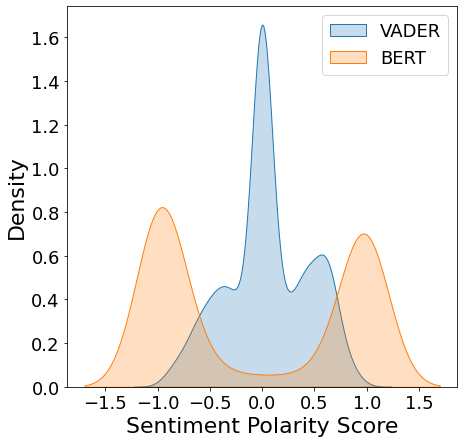

In [ ]:
fig = plt.figure(figsize=(7,7))
sns.plotting_context(font_scale=3)
den = sns.kdeplot(vader_sentiment_scores, shade=True, label="VADER")
den = sns.kdeplot(bert_sentiment_scores, shade=True, label="BERT")
plt.xlabel("Sentiment Polarity Score", fontsize=22)
plt.ylabel("Density", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
legend = plt.legend(fontsize=18)

Interesting; We see that the vader sentiment analyzer outputs more neutral scores (spike at 0). However, the bert based sentiment analyzer show more of a binary classifier characteristics (spikes at -1 and 1)

### Play time

You can try out the vader sentiment analyzer and the bert based sentiment analyzer with your text. Just type in your example into the input field and compile the cell as you used to (shit enter)

In [ ]:
input = "There is no free lunch!" # @param {type: "string"}
print(f"VADER: {get_vader_sentiment(input.strip())}")
print(f"BERT: {get_bert_sentiment(input.strip())}")

VADER: -0.4577
BERT: -0.9772567749023438


Which sentiment analyzer reflects YOUR sentiment perception more?

### More Insights

How are the scores distributed within the news categories?

First, have a look at the distinct categories. 

In [ ]:
print(news.category.unique())

['lifestyle' 'health' 'news' 'sports' 'weather' 'entertainment' 'autos'
 'travel' 'foodanddrink' 'tv' 'finance' 'movies' 'video' 'music']


Put the calculated scores into the news dataframe, such that we can group it by category later.

In [ ]:
news["vader_sentiment_scores"] = vader_sentiment_scores
news["bert_sentiment_scores"] = bert_sentiment_scores

Group by category an calculate mean and standard deviation of the scores.

In [ ]:
news.groupby(["category"])[["vader_sentiment_scores", "bert_sentiment_scores"]].agg(["mean", "std"])

vader_sentiment_scores           bert_sentiment_scores          
                                mean       std                  mean       std
category                                                                      
autos                       0.073473  0.349312             -0.175310  0.901422
entertainment               0.086608  0.430310              0.346752  0.889723
finance                     0.064659  0.354954             -0.211167  0.904080
foodanddrink                0.259741  0.377456              0.356606  0.883892
health                     -0.007071  0.341021             -0.464481  0.784690
lifestyle                   0.139625  0.406425              0.121373  0.942073
movies                     -0.009327  0.382483             -0.257845  0.922072
music                       0.125100  0.455252              0.247541  0.989985
news                       -0.147377  0.386320             -0.376873  0.822609
sports                      0.067865  0.358362             -0.039673  0.919955
travel                      0.148993  0.326113              0.501858  0.861383
tv                          0.113950  0.346946              0.096472  0.958295
video                       0.029538  0.447182             -0.138059  0.960357
weather                    -0.181786  0.332435             -0.139381  0.909819

For example, travel, food & drink, and lifestyle article seems to have on average rather positive sentiment. Whereas the general news category contains on average rather negative articles. 

Well, the weather seems to be (on average) also not so nice :) 


Think about the articles of your favorite news outlets. What does your expierence say in this regard?

## Extracting Emotions

We will use 3 distinct models for each emotion taxonomy we are considering to extract. In our case, Sentiment (d=4), Ekman (d=7), and GoEmotions (d=28). 

In [ ]:
ge_tokenizer = BertTokenizer.from_pretrained("monologg/bert-base-cased-goemotions-original", max_length=50)
ge_model = AutoModelForSequenceClassification.from_pretrained("monologg/bert-base-cased-goemotions-original",  num_labels=28)
goemotions = pipeline(
  model=ge_model, 
  tokenizer=ge_tokenizer, 
  task="text-classification",
  return_all_scores=True,
  function_to_apply='softmax'
)

se_tokenizer = BertTokenizer.from_pretrained("monologg/bert-base-cased-goemotions-group", max_length=50)
se_grouped_model = AutoModelForSequenceClassification.from_pretrained("monologg/bert-base-cased-goemotions-group", num_labels=4)
sentiment = pipeline(
    model=se_grouped_model, 
    tokenizer=se_tokenizer, 
    task="text-classification",
    return_all_scores=True,
    function_to_apply='softmax'
)

ekman_tokenizer = BertTokenizer.from_pretrained("monologg/bert-base-cased-goemotions-ekman", max_length=50)
ekman_model = AutoModelForSequenceClassification.from_pretrained("monologg/bert-base-cased-goemotions-ekman", num_labels=7)
ekman = pipeline(
    model=ekman_model, 
    tokenizer=ekman_tokenizer, 
    task="text-classification",
    return_all_scores=True,
    function_to_apply='softmax'
)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/182 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/235 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.67k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/216 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/182 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/235 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/766 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433M [00:00<?, ?B/s]

Let's try out our model. As input we will use the title of the first entry again

In [ ]:
goemotions(news.title[0],padding=True, truncation=True)

[[{'label': 'admiration', 'score': 8.007995120351552e-07},
  {'label': 'amusement', 'score': 2.5910136969287123e-07},
  {'label': 'anger', 'score': 4.7606701514268934e-07},
  {'label': 'annoyance', 'score': 1.4138341839498025e-06},
  {'label': 'approval', 'score': 6.973801873755292e-07},
  {'label': 'caring', 'score': 2.3456306053049047e-07},
  {'label': 'confusion', 'score': 3.017354686107865e-07},
  {'label': 'curiosity', 'score': 3.4726755870906345e-07},
  {'label': 'desire', 'score': 2.8086375891689386e-07},
  {'label': 'disappointment', 'score': 2.8734277179864876e-07},
  {'label': 'disapproval', 'score': 2.3549100092168374e-07},
  {'label': 'disgust', 'score': 3.802518619977491e-07},
  {'label': 'embarrassment', 'score': 2.695770149330201e-07},
  {'label': 'excitement', 'score': 3.952184215449961e-07},
  {'label': 'fear', 'score': 2.196474753191069e-07},
  {'label': 'gratitude', 'score': 2.3007049776424537e-07},
  {'label': 'grief', 'score': 1.1673624555896822e-07},
  {'label': '

The input text is "The Brands Queen Elizabeth, Prince Charles, and Prince Philip Swear By". The GoEmotion model, which is able to extract 28 distinc emotions-dimensions, determines that the text ist rather on the neutral side.

Is there a difference if we use the model wihch is fine tuned on down-stream classification task with 4 dimension (positive, negative, neutral, ambiguos)

In [ ]:
sentiment(news.title[0],padding=True, truncation=True)

[[{'label': 'ambiguous', 'score': 0.0010440050391480327},
  {'label': 'negative', 'score': 0.0011603262973949313},
  {'label': 'neutral', 'score': 0.9944779872894287},
  {'label': 'positive', 'score': 0.0033176683355122805}]]

No, also our sentiment model (grouped model) determines that the given text is rather neutral.

Finally, we can try our model which is trained to extract emotions within the EKMAN taxonomy. 

In [ ]:
ekman(news.title[0],padding=True, truncation=True)

[[{'label': 'anger', 'score': 0.0008247915538959205},
  {'label': 'disgust', 'score': 0.00024021478020586073},
  {'label': 'fear', 'score': 9.224303357768804e-05},
  {'label': 'joy', 'score': 0.008068178780376911},
  {'label': 'neutral', 'score': 0.9892375469207764},
  {'label': 'sadness', 'score': 0.0008200480369850993},
  {'label': 'surprise', 'score': 0.0007169389282353222}]]

### Play time

You can try out all three models with your own text. Select the model from the dropdown, provide your phrase, and pres shift-enter

In [ ]:
model = "sentiment" # @param ["sentiment", "ekman", "goemotion"]
input = "This is so messed up!" # @param {type: "string"}
out = None
if model == "sentiment":
  out = sentiment(input,padding=True, truncation=True)
elif model == "ekman":
  out = ekman(input,padding=True, truncation=True)
else:
  out = goemotions(input,padding=True, truncation=True)

out

[[{'label': 'ambiguous', 'score': 0.005131022538989782},
  {'label': 'negative', 'score': 0.9771953225135803},
  {'label': 'neutral', 'score': 0.01454135775566101},
  {'label': 'positive', 'score': 0.0031322792638093233}]]

### Some Insights

Let us consider the Ekman emotions as our underlying emotion taxonomy. We go through all news and extract the ekman emotions (d=7). We create new pandas data frame based on using the extracted emotions and concatenate the outcome with the news dataframe, such that we can investigate the emotion dimension for each category.

In [ ]:
news_ekman_scores = [
    dict([
        (l["label"],l["score"])
        for l in ekman(title,padding=True, truncation=True)[0]
        ]) 
    for title in news.title
    ]

In [ ]:
news_emotions = pd.DataFrame(news_ekman_scores)

In [ ]:
news_and_emotions = pd.concat([news,news_emotions], axis=1)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text major ticklabel objects>)

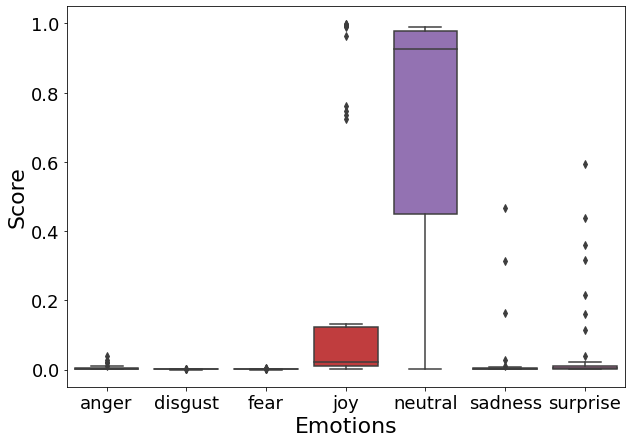

In [ ]:
input_category = "travel" # @param ['lifestyle', 'health', 'news', 'sports', 'weather', 'entertainment', 'autos', 'travel', 'foodanddrink', 'tv', 'finance', 'movies', 'video', 'music']
fig = plt.figure(figsize=(10,7))
sns.plotting_context(font_scale=3)
sns.boxplot(x="variable", y="value", data=pd.melt(news_and_emotions[news_and_emotions.category == input_category][["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]]))
plt.xlabel("Emotions", fontsize=22)
plt.ylabel("Score", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

Throughout the categories, the news titles have a rather high neutral score. Which we would actually expect from news. Do you observe something surprising ?

## Finding Recommendations

First compute the semantic representations of the news titles (we do not use the emotions information), i.e., we compute 384 dimenstional embeddings given the news title as input.

In [ ]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
embeddings = model.encode(news.title)

Now we can fit a KNN model to find the nearest neighbors, i.e., most similar embedding given an embedding as imput :) 

In [ ]:
knn = NearestNeighbors(n_neighbors=11)
knn.fit(embeddings)

NearestNeighbors(n_neighbors=11)

Let's find out what the closest 10 articles for the first entry in our data set are. 

In [ ]:
# select indices of k nearest neighbours
neighbours = knn.kneighbors([embeddings[0]], return_distance = False)
print(news.iloc[neighbours[0]].title.values)

['The Brands Queen Elizabeth, Prince Charles, and Prince Philip Swear By'
 "Queen Elizabeth's Favorite Beauty Products Have Stood the Test of Time"
 'What Do Prince George & Princess Charlotte Know About Their Royal Roles?'
 '6 gorgeous royal family heirlooms that Kate Middleton wears regularly'
 "Prince George's Royal Life in Photos"
 'The surprising age differences between your favorite royal couples'
 "Queen Elizabeth's Cousin Says Royal Family 'Don't Communicate Very Well'"
 'Every outfit Duchess Kate has worn in 2019'
 '55 Photos of the Spanish Royal Family Then and Now'
 'When royals lose their tempers, from the Queen to Kate Middleton'
 "25 Photos of the Royal Family at Balmoral Castle, Queen Elizabeth's Favorite Home"]


The first title, i.e., "The Brands Queen Elizabeth, Prince Charles, and Prince Philip Swear By" is our input. The other titles, are the closes neighbors, i.e., our recommendations. Seems to work fine right?

Let's incorporate emotions, in this case based on the ekman taxonomy. 

In [ ]:
embeddings_and_emotions = np.concatenate((embeddings, news_emotions.to_numpy()),axis=1)

Now fit another knn model with our new emotion aware embeddings.

In [ ]:
knn_e = NearestNeighbors(n_neighbors=11)
knn_e.fit(embeddings_and_emotions)

NearestNeighbors(n_neighbors=11)

We will use again the first entry in our sample as input. Is there a change compared to the non aware results ?

In [ ]:
# select indices of k nearest neighbours
neighbours_e = knn_e.kneighbors([embeddings_and_emotions[0]], return_distance = False)
print(news.iloc[neighbours_e[0]].title.values)

['The Brands Queen Elizabeth, Prince Charles, and Prince Philip Swear By'
 "Prince George's Royal Life in Photos"
 '6 gorgeous royal family heirlooms that Kate Middleton wears regularly'
 "Queen Elizabeth's Cousin Says Royal Family 'Don't Communicate Very Well'"
 'Every outfit Duchess Kate has worn in 2019'
 '55 Photos of the Spanish Royal Family Then and Now'
 'When royals lose their tempers, from the Queen to Kate Middleton'
 "25 Photos of the Royal Family at Balmoral Castle, Queen Elizabeth's Favorite Home"
 'Pakistan PM reveals what he told Prince William at lunch'
 '50 Incredible Photos of the Swedish Royal Family Through the Years'
 "All the Things You Didn't Know About 'The Crown'"]


In [ ]:
news_and_emotions.iloc[neighbours_e[0]][["title", "anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]]

,title,anger,disgust,fear,joy,neutral,sadness,surprise
0,"The Brands Queen Elizabeth, Prince Charles, an...",0.000825,0.000240,0.000092,0.008068,0.989238,0.000820,0.000717
46,Prince George's Royal Life in Photos,0.000932,0.000182,0.000119,0.012231,0.983476,0.000997,0.002063
208,6 gorgeous royal family heirlooms that Kate Mi...,0.002866,0.000299,0.000155,0.197368,0.792787,0.002443,0.004081
107,Queen Elizabeth's Cousin Says Royal Family 'Do...,0.006567,0.000292,0.000127,0.013291,0.976313,0.001615,0.001795
27,Every outfit Duchess Kate has worn in 2019,0.000730,0.000139,0.000103,0.011204,0.985364,0.000816,0.001645
874,55 Photos of the Spanish Royal Family Then and...,0.000795,0.000264,0.000090,0.004048,0.992490,0.000982,0.001329
105,"When royals lose their tempers, from the Queen...",0.001752,0.000177,0.000120,0.005542,0.985169,0.001770,0.005470
42,25 Photos of the Royal Family at Balmoral Cast...,0.000907,0.000252,0.000090,0.012726,0.983515,0.001172,0.001338
187,Pakistan PM reveals what he told Prince Willia...,0.001129,0.000167,0.000144,0.010165,0.983537,0.000897,0.003961
307,50 Incredible Photos of the Swedish Royal Fami...,0.001121,0.000184,0.000115,0.012193,0.983856,0.000911,0.001621


### Play time

Explore the emotion-aware and non-emotion-aware recommendation for the first 10 news entries. Note, the first line is always the news title under consideration, i.e., the target news for which we compute recommendations.

In [ ]:
emotion_awareness = True # @param {type: "boolean"}
news_index = 1 # @param [0,1,2,3,4,5,6,7,8,9] {type:"raw"}
knn_model = None
emb = None
if emotion_awareness:
  knn_model = knn_e
  emb = embeddings_and_emotions
else:
  knn_model = knn
  emb = embeddings

recommendations = knn_model.kneighbors([emb[news_index]], return_distance = False)
print(news.iloc[recommendations[0]].title.values)
news_and_emotions.iloc[recommendations[0]][["title", "anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]]


['50 Worst Habits For Belly Fat'
 '27 bad eating habits you need to stop right now'
 '30 Healthy Habits Fit People Live By'
 'If You Have a Slow Metabolism, Here Are 5 Doctor-Approved Ways to Burn Belly Fat'
 "45 Sneaky Signs You're Unhealthier Than You May Think"
 "Grocery shopping mistakes you don't want to make"
 '50 Foods You Should Never Eat, According to Health Experts'
 "Those Grueling Workouts May Not Help You Lose Belly Fat, but Here's What Will"
 'Ways to Lose Weight: 36 Fast, Easy Tips'
 "Woman who ate McDonald's EVERY DAY before dinner sheds 154lbs with the help of a gastric band after deciding she didn't want to be a 'shell of a mother' anymore"
 '40 Health Symptoms You Should Never Ignore']


,title,anger,disgust,fear,joy,neutral,sadness,surprise
1,50 Worst Habits For Belly Fat,0.043971,0.130189,0.001344,0.014646,0.771820,0.030892,0.007137
672,27 bad eating habits you need to stop right now,0.045074,0.001484,0.000820,0.036789,0.885347,0.018824,0.011662
441,30 Healthy Habits Fit People Live By,0.007406,0.000777,0.000158,0.006243,0.982327,0.002228,0.000861
292,"If You Have a Slow Metabolism, Here Are 5 Doct...",0.006820,0.000566,0.000548,0.126046,0.851093,0.003115,0.011812
185,45 Sneaky Signs You're Unhealthier Than You Ma...,0.083561,0.036060,0.003482,0.015665,0.804191,0.034674,0.022367
501,Grocery shopping mistakes you don't want to make,0.067681,0.001309,0.000164,0.010709,0.913681,0.003129,0.003328
10,"50 Foods You Should Never Eat, According to He...",0.006396,0.000404,0.000137,0.010913,0.978834,0.001172,0.002144
154,Those Grueling Workouts May Not Help You Lose ...,0.119262,0.005453,0.004885,0.313626,0.409043,0.060073,0.087658
631,"Ways to Lose Weight: 36 Fast, Easy Tips",0.001343,0.000279,0.000123,0.007223,0.988452,0.001597,0.000981
654,Woman who ate McDonald's EVERY DAY before dinn...,0.012347,0.000768,0.000481,0.010062,0.956190,0.012869,0.007283


Is there any difference in emotion aware and non-emotion-aware recommendations? If so, are the recommendation better or worse / does it make sense?